# This notebook is used to determine the output of the calibration illumination system and measure the amount of signal on the detector from an ATArchiver image. The code is meant for flats, but can be used for other purposes.

In [ ]:
from astropy.io import fits
import astropy.stats
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import csv

In [2]:
import lsst.ts

Could not import lsstcppimport; please ensure the base package has been built (not just setup).



In [3]:
import lsst.ts

ModuleNotFoundError: No module named 'lsst.ts.standardscripts'

In [3]:
if True:
    import asyncio
    import logging

    from lsst.ts import salobj
    from lsst.ts.standardscripts.scripts.auxtel import calsys_take_narrowband_data

    async def main(index):
        script = calsys_take_narrowband_data(index=index)
        script.log.setLevel(logging.INFO)
        script.log.addHandler(logging.StreamHandler())
        print("*** configure")
        config_data = script.cmd_configure.DataType()
        config_data.config = "develop/config/calsys_take_narrowband_data.yaml"
        config_id_data = salobj.CommandIdData(1, config_data)
        await script.do_configure(config_id_data)
        print("*** run")
        await script.do_run(None)
        print("*** done")


ModuleNotFoundError: No module named 'lsst.ts.standardscripts'

In [ ]:
asyncio.get_event_loop().run_until_complete(main(index=1))

In [4]:
# the calsys_take_narrowband_data script outputs a CSV file, but the URLs are messed up. So this fixes them and writes a new file
new_rows = []
csv_dir='/home/saluser/develop/calsys_take_narrowband_data_fits_files/'
#csv_dir='/home/saluser/develop/calsys_take_test_data_fits_files/'
#csv_dir='/home/saluser/develop/'
csv_filename_root='calsys_take_narrowband_data_2019-04-03'
with open(csv_dir+csv_filename_root+'.csv',"r") as csvfile:
    data_reader = csv.DictReader(csvfile)
    headers = data_reader.fieldnames
    for row in data_reader:
        new_row = row
        electrometer_url = row["Electrometer Fits File"]
        fiber_spectrograph_url = row["Fiber Spectrograph Fits File"]
        electrometer_name = electrometer_url.split('/')[-1]
        new_row["Electrometer Fits File"] = electrometer_name + ".fits"
        fiber_spectrograph_name = fiber_spectrograph_url.split('/')[-1]
        new_row["Fiber Spectrograph Fits File"] = fiber_spectrograph_name
        new_rows.append(new_row)
with open(csv_dir+csv_filename_root+'-reformatted.csv',"w") as csvfile:
    data_writer = csv.DictWriter(csvfile, fieldnames=headers)
    data_writer.writeheader()
    for row in new_rows:
        data_writer.writerow(row)

# Read in the CSV file which has cleaned URLs
new_rows = []
with open(csv_dir+csv_filename_root+'-reformatted.csv',"r") as csvfile:
    data_reader = csv.DictReader(csvfile)
    data_reader_list = list(data_reader)
    #exposure_time_1 = data_reader_list[0]["Exposure Time"]
    #print(exposure_time_1)
        
print(data_reader.fieldnames)

['ATArchiver Image Name', 'ATArchiver Image Sequence Name', 'Exposure Time', 'Fiber Spectrograph Exposure Time', 'Monochromator Grating', 'Monochromator Wavelength', 'Monochromator Entrance Slit Size', 'Monochromator Exit Slit Size', 'Fiber Spectrograph Fits File', 'Electrometer Fits File']


In [5]:
print(data_reader_list[-1]['ATArchiver Image Name'])
print(data_reader_list[-1]['Exposure Time'])
print(data_reader_list[-1]['Fiber Spectrograph Exposure Time'])
print(data_reader_list[-1]['Monochromator Wavelength'])
print(data_reader_list[-1]['Monochromator Exit Slit Size'])

AT_O_20190403_000072-ats-wfs_ccd.fits
1.0
0.2
432.0
0.15


In [6]:
# Read in a fiber spectrograph file, which is just the last one in the list
dir='/home/saluser/develop/calsys_take_narrowband_data_fits_files/fiber_spectrograph_fits_files/'
#dir='/home/saluser/develop/calsys_take_test_data_fits_files/fiber_spectrograph_fits_files/'
#filename=dir+'testKiloarc1553106436.910112.fits'
filename=dir+data_reader_list[-1]['Fiber Spectrograph Fits File']

print('Opening file {}'.format(filename))
#fits_image_filename = fits.util.get_testdata_filepath(filename)
hdul = fits.open(filename)
xdata=(hdul[0].data)[:,0]
ydata=(hdul[0].data)[:,1]
#print(repr(hdul[0].header))

Opening file /home/saluser/develop/calsys_take_narrowband_data_fits_files/fiber_spectrograph_fits_files/testKiloarc1554332280.834453.fits


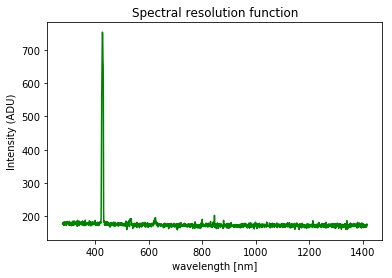

In [7]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(xdata, ydata,'-g')
    plt.title('Spectral resolution function')
    plt.xlabel('wavelength [nm]')
    plt.show()
    plt.close()

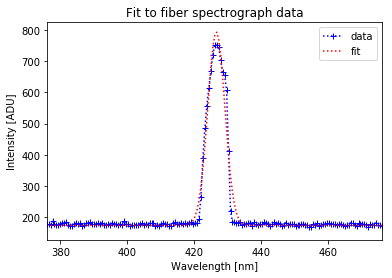

Amplitude [ADU] = 620
peak (mean) [nm] = 426.59
width (sigma) [nm] = 2.566
FWHM [nm] = 6.043


In [11]:
# Fit a guassian to the profile
mean = xdata[np.argmax(ydata)] # assume the peak we want is the maximum value (NOT ALWAYS THE CASE!)
#mean = 432.   #note this correction
sigma = 2.0        #note this correction
offset=np.median(ydata)

def gaus(x,a,x0,sigma, offset):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+offset

popt,pcov = curve_fit(gaus,xdata,ydata,p0=[8000.0,mean,sigma, offset])

plt.plot(xdata,ydata,'b+:',label='data')
plt.plot(xdata,gaus(xdata,*popt),'r:',label='fit')
dx=50
plt.xlim([mean-dx,mean+dx])
#plt.ylim([0,2000])
plt.legend()
plt.title('Fit to fiber spectrograph data')
plt.ylabel('Intensity [ADU]')
plt.xlabel('Wavelength [nm]')
plt.show()

print('Amplitude [ADU] = {:.0f}'.format(popt[0]))
print('peak (mean) [nm] = {:.2f}'.format(popt[1]))
print('width (sigma) [nm] = {:0.3f}'.format(popt[2]))
print('FWHM [nm] = {:0.3f}'.format(popt[2]*2.355))

In [12]:
# Now read in the camera image to look at the signal of the flats

In [16]:
# Now read in the camera image
# For now just calculate the mediam signal per amp

# Read in image
dir = '/mnt/dmcs/2019-04-03/'
atcamera_fname=data_reader_list[-1]['ATArchiver Image Name']
atcamera_fname='AT_O_20190403_000071-ats-wfs_ccd.fits'

full_file_name=dir+atcamera_fname
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
im=hdu_list[12].data # for camera data

Opening /mnt/dmcs/2019-04-03/AT_O_20190403_000071-ats-wfs_ccd.fits


In [18]:
# Check median counts on amplifiers (for flat level testing)
if False:
    # Create an array of the median values
    med_arr=np.zeros(16)
    stddev_arr=np.zeros(16)

    for amp in range(len(hdu_list)-1):
        if amp == 0:
            continue
    #    med_arr[amp]=np.median(hdu_list[amp].data)
        # Calculate mean, median, stddev
        tmp = astropy.stats.sigma_clipped_stats(hdu_list[amp].data, sigma=2)
        med_arr[amp]= tmp[1]
        stddev_arr[amp] = tmp[2]
        print('Median and Stddev values of amplifier {} is {} and {}'.format(amp,med_arr[amp], stddev_arr[amp]))

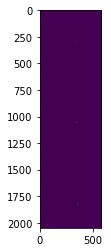

In [19]:
plt.imshow(hdu_list[12].data)

In [31]:
hdu_list[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
EXTNAME = 'PRIMARY '                                                            
ORIGIN  = 'LSST DM Header Service' / FITS file originator                       
DATE    = '2019-03-22T22:39:43.664' / Creation Date and Time of File            
DATE-OBS= '2019-03-22T22:39:25.494' / Date of the observation (image acquisition
DATE-END= '2019-03-22T22:39:25.494' / end date of the observation               
MJD     =      58564.944255372 / Modified Julian Date that the file was written 
MJD-OBS =     58564.94404506

In [32]:
tmp[3]

IndexError: tuple index out of range